In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table
import time
import plotly.express as px
from jdaviz import Imviz

%matplotlib inline

imviz = Imviz()



**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-065 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-068
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf


In [2]:
import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger().setLevel(logging.ERROR)
import os
import copy
from copy import deepcopy
import math
import statistics
import galsim
import numpy as np
from jdaviz import Imviz
from romanisim import parameters, catalog, wcs, l3, psf, util, log, image
import roman_datamodels.maker_utils as maker_utils
import roman_datamodels.datamodels as rdd
from astropy.coordinates import SkyCoord
from astropy import units as u

In [3]:
os.environ["WEBBPSF_PATH"] = "/Users/phuwe/src/roman/webbpsf-data"

In [4]:
# Define random seed
rng_seed = 42

# Obtain pointing
ra_ref = parameters.default_mosaic_parameters_dictionary['wcsinfo']['ra_ref']
dec_ref = parameters.default_mosaic_parameters_dictionary['wcsinfo']['dec_ref']

# Set metadata and capture filter
metadata = deepcopy(parameters.default_mosaic_parameters_dictionary)
filter_name = metadata['basic']['optical_element']

# Set exposure time
exptimes = [600]

# Create catalog of objects
cen = SkyCoord(ra=(ra_ref * u.deg).to(u.rad), dec=(dec_ref * u.deg).to(u.rad))
cat = catalog.make_cosmos_galaxies(cen, radius=0.03, bandpasses=[filter_name])

In [5]:
# Create bounds from the object list
twcs = wcs.get_mosaic_wcs(metadata)
allx, ally = twcs.world_to_pixel(cat['ra'], cat['dec'])

# Obtain the sample extremums
xmin = min(allx)
xmax = max(allx)
ymin = min(ally)
ymax = max(ally)

# Obtain WCS center
xcen, ycen = twcs.world_to_pixel(ra_ref, dec_ref)

# Determine maximum extremums from WCS center
xdiff = max([math.ceil(xmax - xcen), math.ceil(xcen - xmin)]) + 1
ydiff = max([math.ceil(ymax - ycen), math.ceil(ycen - ymin)]) + 1

# Create context map preserving WCS center
context = np.ones((1, 2 * ydiff, 2 * xdiff), dtype=np.uint32)

# Generate properly sized WCS
moswcs = wcs.get_mosaic_wcs(metadata, shape=(context.shape[1:]));

# Simulate mosaic
mosaic, extras = l3.simulate(context.shape[1:], moswcs, exptimes[0],
                             filter_name, cat, metadata=metadata,
                             seed=rng_seed);
mos_mod = rdd.MosaicModel(mosaic)

INFO:romanisim:Simulating filter F184...
INFO:romanisim:Adding 1407 sources to image...
INFO:romanisim:Rendered 1407 sources...
INFO:romanisim:Simulation complete.


In [7]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')  # ErfaWarning
    imviz.load_data(mos_mod, ext='data', data_label='exposure 1')

In [8]:
imviz.show('sidecar:split-right', height=1000)
orientation = imviz.plugins['Orientation']

#orientation.align_by = 'WCS'

In [16]:
# Simulated catalog for comparison

simcat = catalog.make_galaxies(cen, n=len(cat), radius=0.03, index=1, faintmag=26,
        bandpasses=[filter_name], hlr_at_faintmag=1)

In [17]:
import statistics as stats
# COSMOS sources
print(stats.mean(cat['F184']))
print(stats.stdev(cat['F184']))

1.0068571030595023e-09
2.118597091591826e-09


In [18]:
# Simulated sources
print(stats.mean(simcat['F184']))
print(stats.stdev(simcat['F184']))

1.01351524e-10
1.3045514295138233e-10


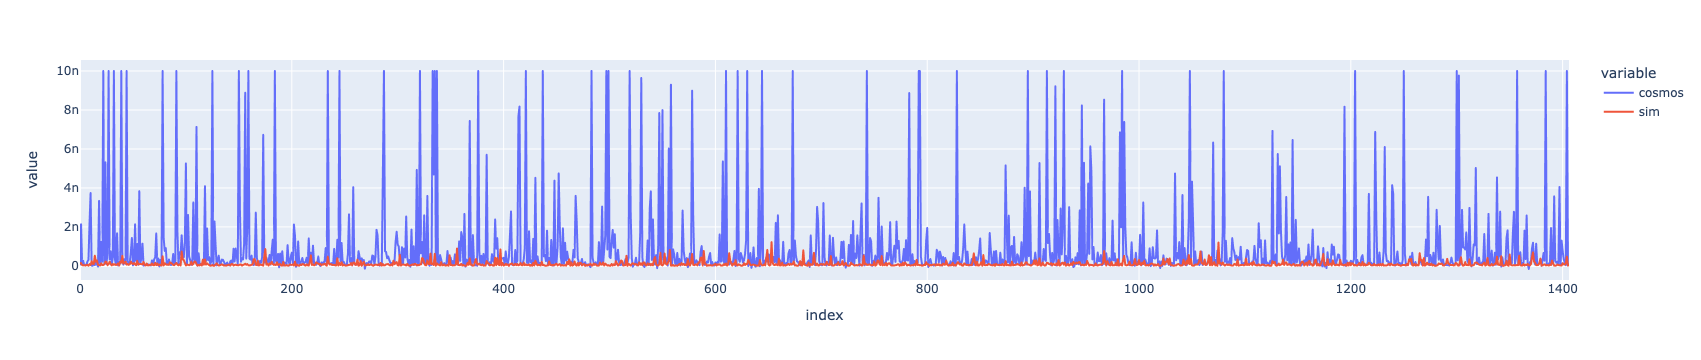

In [19]:
# Chop off very bright objects
max_cos = cat['F184']
max_cos[max_cos > 1.0e-8] = 1.0e-8

# Plot
fig1 = px.line({"cosmos":max_cos, "sim":simcat['F184'],})
fig1.show()

1.2666813406090869
8.036783455936002


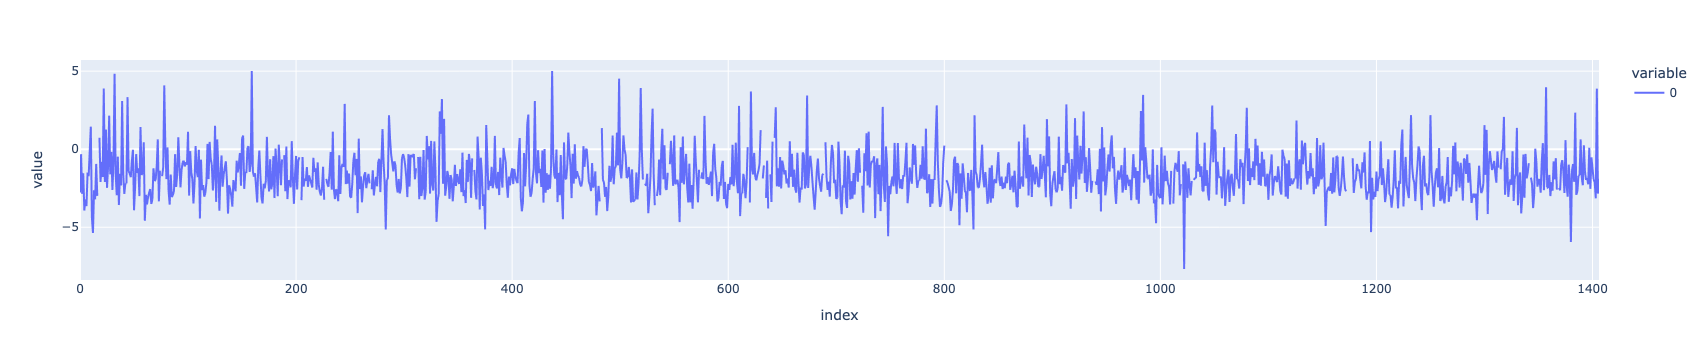

In [20]:
# plot cosmos fwhm world / flux radius
# should be in agreement ? 
ratio = (cat['FL50_F184'] * 0.15 / 3600) / cat['FWHM'] # Original units -> (pix / deg)
print(stats.mean(ratio))
print(stats.stdev(ratio))
fig2 = px.line(np.log(ratio))
fig2.show()